# Install dependencies

In [30]:
!pip install Sastrawi tensorflow scikit-learn gensim wordcloud pipreqs

# 1. Import Library

In [26]:
import pandas as pd, numpy as np
import re, string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 2. Load & Preprocess

In [10]:
# Load data
df = pd.read_csv("telkomsel_reviews.csv")

# Preprocessing
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
stemmer = StemmerFactory().create_stemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess(text):
    cleaned = clean_text(text)
    tokens = nltk.word_tokenize(cleaned)
    filtered = [w for w in tokens if w not in stopwords]
    stemmed = [stemmer.stem(w) for w in filtered]
    return " ".join(stemmed)

df['clean_review'] = df['text'].apply(preprocess)

# Labeling
def score_to_sentiment(score):
    if score <= 2:
        return "negatif"
    elif score == 3:
        return "netral"
    else:
        return "positif"

df['label'] = df['rating'].apply(score_to_sentiment)
df = df[['clean_review', 'label']]
df.columns = ['text', 'label']

# Save
df.to_csv("preprocessed_telkomsel.csv", index=False)
df.head()

,text,label
0,aplikasi sering eror keluar sendiri hapus apli...,negatif
1,aplikasi nya makin kesini makin jelek mau ngec...,negatif
2,kuota mahal jaring lambat ga baik padahal dulu...,negatif
3,bantu sya,positif
4,niat gak sih bikin apk log in aplikasi aja ten...,negatif


In [27]:
# Load data
df = pd.read_csv('preprocessed_telkomsel.csv')

# Gabungkan semua teks dalam satu string
all_text = ' '.join(df['text'].astype(str))

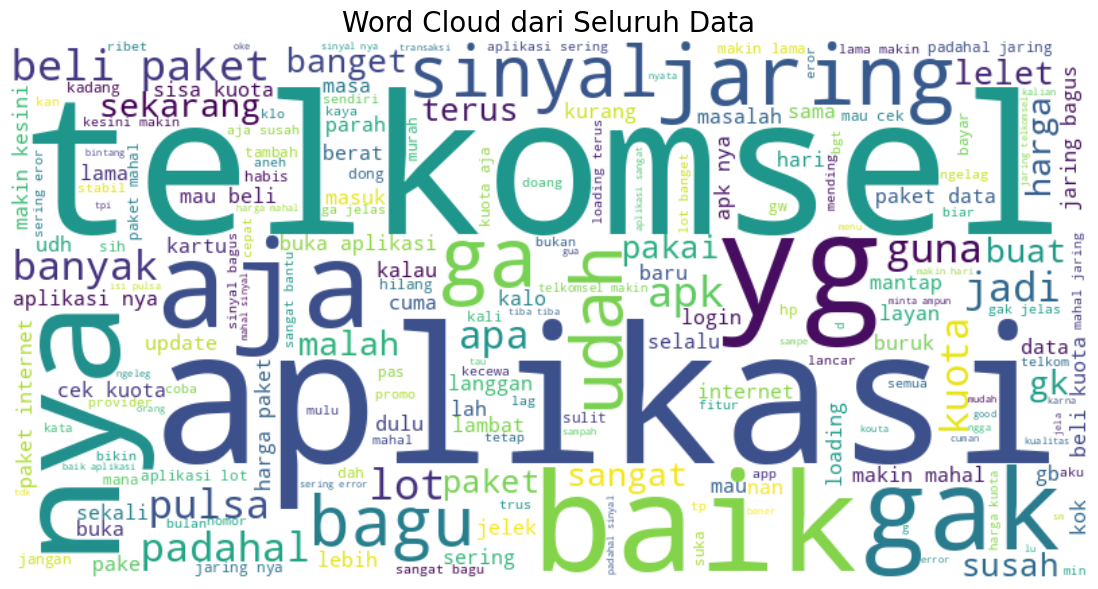

In [28]:
# Buat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Tampilkan
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dari Seluruh Data", fontsize=20)
plt.show()

In [11]:
from sklearn.utils import resample

# Pisahkan data berdasarkan label
netral_df = df[df['label'] == 'netral']
negatif_df = df[df['label'] == 'negatif']
positif_df = df[df['label'] == 'positif']

# Oversample positif dan negatif hingga 9000-an
positif_upsampled = resample(positif_df, replace=True, n_samples=9000, random_state=42)
negatif_upsampled = resample(negatif_df, replace=True, n_samples=9000, random_state=42)

# Undersample netral agar seimbang
netral_downsampled = resample(netral_df, replace=True, n_samples=9000, random_state=42)

# Gabung kembali
df_balanced = pd.concat([positif_upsampled, negatif_upsampled, netral_downsampled])

# Acak ulang data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['label'].value_counts())

# Label encoding
le = LabelEncoder()
df_balanced['encoded'] = le.fit_transform(df_balanced['label'])

label
positif    9000
netral     9000
negatif    9000
Name: count, dtype: int64


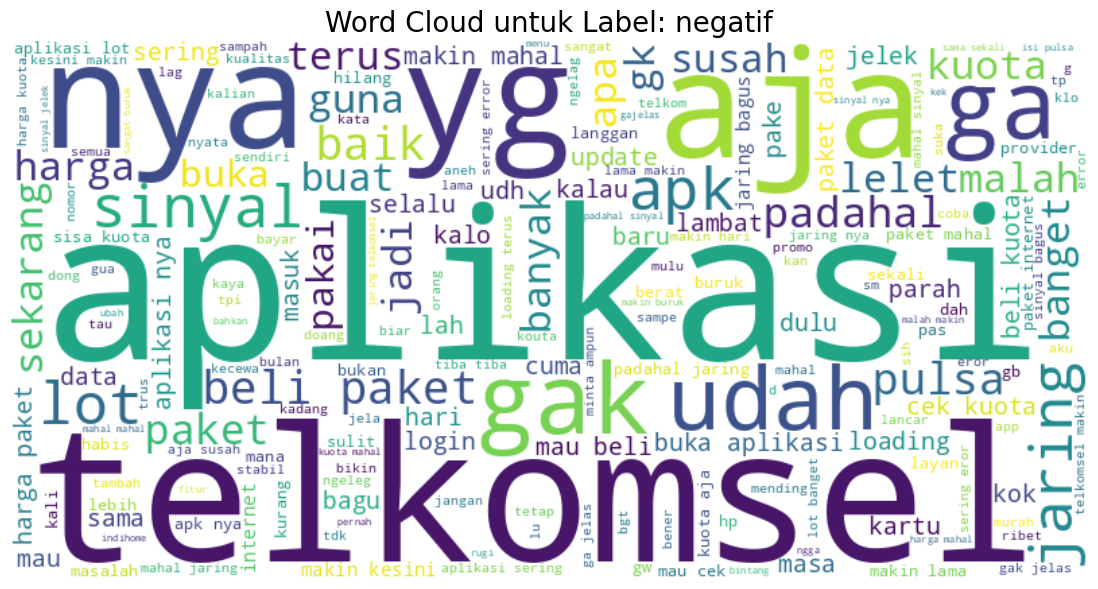

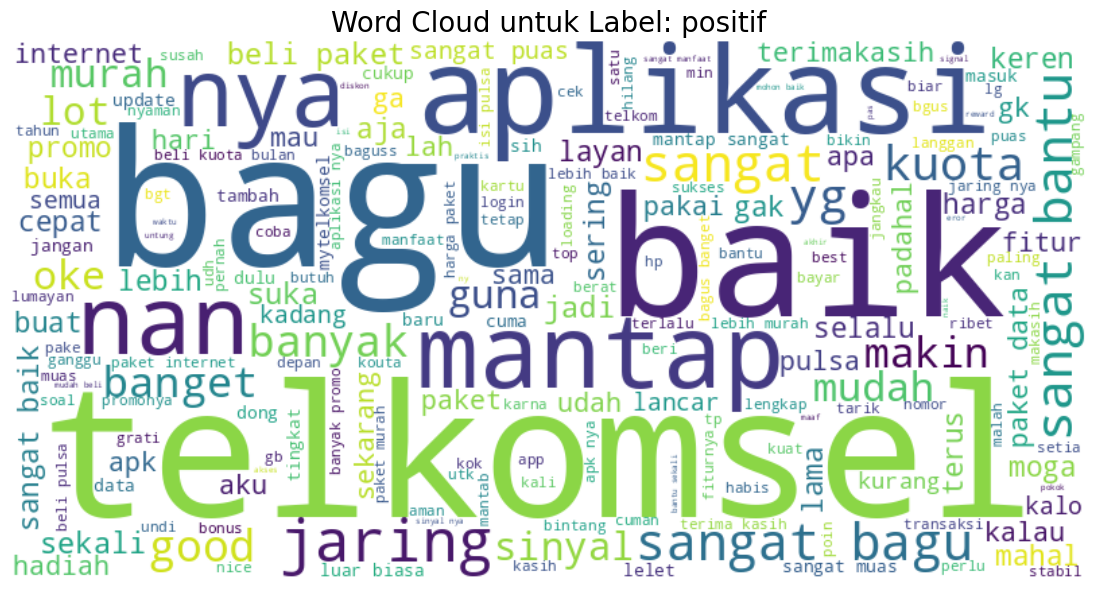

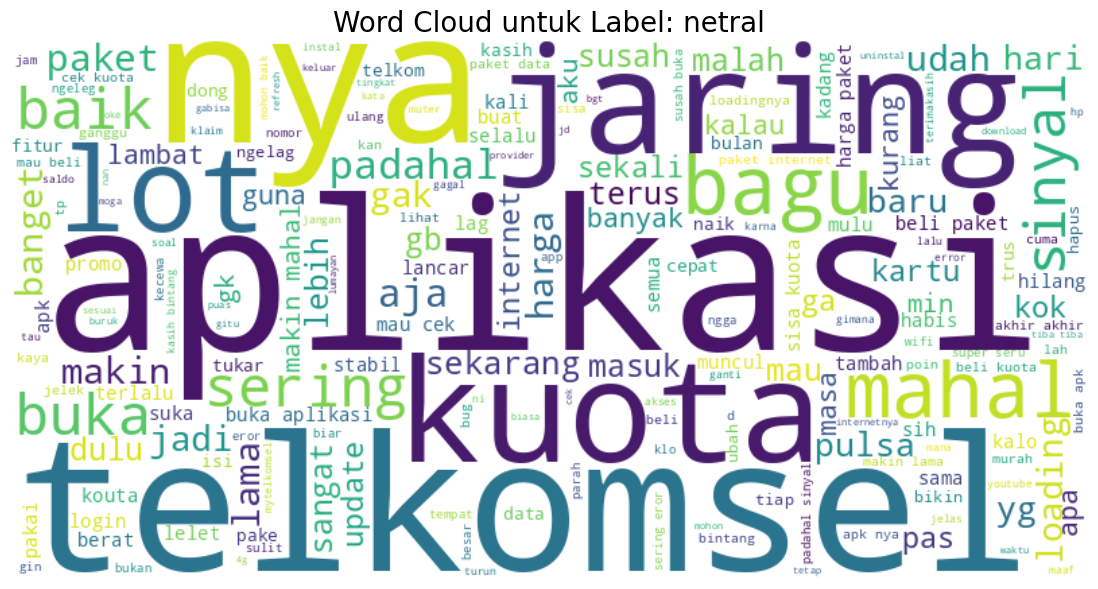

In [29]:
# Untuk label: negatif, netral, positif
for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud untuk Label: {label}", fontsize=20)
    plt.show()

# 3. Skema 2: SVM + TF-IDF

In [13]:
tfidf = TfidfVectorizer(max_features=5000)
X2 = tfidf.fit_transform(df_balanced['text'])
y2 = df_balanced['encoded']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42)

svm = LinearSVC()
svm.fit(X_train2, y_train2)
y_pred2 = svm.predict(X_test2)
print("SVM Accuracy:", accuracy_score(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2, target_names=le.classes_))

def pred_svm(text):
    tf = tfidf.transform([text])
    p = svm.predict(tf)
    return le.inverse_transform(p)[0]
print(pred_svm("Jaringan lancar dan cepat sekali"))

SVM Accuracy: 0.8962962962962963
              precision    recall  f1-score   support

     negatif       0.92      0.84      0.88      1800
      netral       0.87      0.91      0.89      1800
     positif       0.90      0.94      0.92      1800

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.90      5400
weighted avg       0.90      0.90      0.90      5400

positif


# 4. Skema 3: RF + Word2Vec

In [14]:
df_balanced['tokens'] = df_balanced['text'].apply(nltk.word_tokenize)
w2v = Word2Vec(sentences=df_balanced['tokens'], vector_size=100, window=5, min_count=1)
def doc_vec(tokens):
    t = [w for w in tokens if w in w2v.wv]
    return np.mean(w2v.wv[t], axis=0) if t else np.zeros(100)
wv = np.vstack(df_balanced['tokens'].apply(doc_vec))

# Add label encoding
le = LabelEncoder()
df_balanced['encoded'] = le.fit_transform(df_balanced['label'])

y3 = df_balanced['encoded']
X_train3, X_test3, y_train3, y_test3 = train_test_split(wv, y3, test_size=0.3, stratify=y3, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train3, y_train3)
y_pred3 = rf.predict(X_test3)
print("RF Accuracy:", accuracy_score(y_test3, y_pred3))
print(classification_report(y_test3, y_pred3, target_names=le.classes_))

def pred_rf(text):
    tok = nltk.word_tokenize(text)
    vec = doc_vec(tok).reshape(1,-1)
    p = rf.predict(vec)
    return le.inverse_transform(p)[0]
print(pred_rf("Sering crash, tapi fitur sudah cukup lengkap"))

RF Accuracy: 0.9641975308641976
              precision    recall  f1-score   support

     negatif       0.97      0.96      0.97      2700
      netral       0.98      0.96      0.97      2700
     positif       0.94      0.97      0.95      2700

    accuracy                           0.96      8100
   macro avg       0.96      0.96      0.96      8100
weighted avg       0.96      0.96      0.96      8100

positif


# 5. Skema 1: LSTM

In [17]:
MAX_VOCAB = 10000; MAX_LEN = 150
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(df_balanced['text'])
seq = tokenizer.texts_to_sequences(df_balanced['text'])
X = pad_sequences(seq, maxlen=MAX_LEN)
y = to_categorical(df_balanced['encoded'])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,
                                                          test_size=0.2, stratify=y,
                                                          random_state=42)

model = Sequential([
  Embedding(MAX_VOCAB,128),
  SpatialDropout1D(0.3),
  Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
  Dense(3,activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train1, y_train1, validation_split=0.1, epochs=20, batch_size=128, callbacks=[es])

y_pred1 = np.argmax(model.predict(X_test1),axis=1)
y_true1 = np.argmax(y_test1,axis=1)
print("LSTM Accuracy:", accuracy_score(y_true1, y_pred1))
print(classification_report(y_true1, y_pred1, target_names=le.classes_))

# Inference LSTM
def pred_lstm(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN)
    pred = np.argmax(model.predict(pad), axis=1)
    return le.inverse_transform(pred)[0]
print(pred_lstm("Aplikasi ini sangat lemot dan sering error"))

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.5197 - loss: 0.9312 - val_accuracy: 0.7606 - val_loss: 0.5887
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8037 - loss: 0.5099 - val_accuracy: 0.8458 - val_loss: 0.4134
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.8649 - loss: 0.3650 - val_accuracy: 0.8648 - val_loss: 0.3569
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8893 - loss: 0.2976 - val_accuracy: 0.8847 - val_loss: 0.3103
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9102 - loss: 0.2510 - val_accuracy: 0.9005 - val_loss: 0.2817
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9218 - loss: 0.2217 - val_accuracy: 0.9083 - val_loss: 0.2691
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9281 - loss: 0.2020 - val_accuracy: 0.9093 - val_loss: 0.2703
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9336 - loss: 0.1907 - val_accu